In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers


num_classes = 9 #@param
batch_size = 64 #@param

print("Loading saliency data")
dataset_path = 'data/train'
train_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

dataset_path = 'data/test'
val_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


print("Loading bounding box data")
dataset_path = 'bboxes/train'
bbx_train_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

dataset_path = 'bboxes/test'
bbx_val_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


train_dataset = bbx_train_dataset
val_dataset = bbx_val_dataset

2025-01-30 15:55:17.161850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738248917.180793 1657798 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738248917.185875 1657798 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 15:55:17.203469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading saliency data
Found 16110 files belonging to 9 classes.


I0000 00:00:1738248919.722791 1657798 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10386 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 7713 files belonging to 9 classes.
Loading bounding box data
Found 11010 files belonging to 9 classes.
Found 6612 files belonging to 9 classes.


In [2]:
# One hot encode classes
def preprocess(x, y):
    y = tf.one_hot(y, depth=num_classes)
    return x, y

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


input_shape = train_dataset.element_spec[0].shape[1:]


from utils import CustomVGG19Model

model = CustomVGG19Model(input_shape=input_shape, num_classes=num_classes, apply_augmentation=True)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,189,769 (77.02 MB)

 Trainable params: 165,385 (646.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [3]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


I0000 00:00:1738248926.257946 1657892 cuda_dnn.cc:529] Loaded cuDNN version 90300


173/173 ━━━━━━━━━━━━━━━━━━━━ 114s 589ms/step - accuracy: 0.1986 - loss: 2.1040 - val_accuracy: 0.2548 - val_loss: 2.0205
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 569ms/step - accuracy: 0.4090 - loss: 1.8596 - val_accuracy: 0.4690 - val_loss: 1.8198
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 569ms/step - accuracy: 0.5022 - loss: 1.6437 - val_accuracy: 0.4799 - val_loss: 1.7056
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 570ms/step - accuracy: 0.5711 - loss: 1.4499 - val_accuracy: 0.5330 - val_loss: 1.5793
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 569ms/step - accuracy: 0.6135 - loss: 1.3151 - val_accuracy: 0.5777 - val_loss: 1.4922
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 568ms/step - accuracy: 0.6415 - loss: 1.1959 - val_accuracy: 0.5679 - val_loss: 1.4577
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 568ms/step - accuracy: 0.6645 - loss: 1.1021 - val_accuracy: 0.5930 - val_loss: 1.3964
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 569ms/step - accuracy: 0.6834 - loss: 1.0351 - va

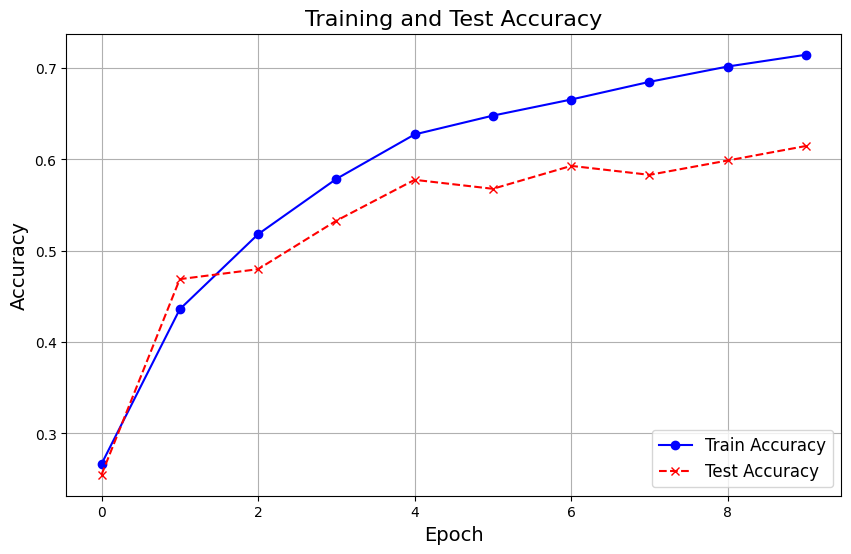

In [4]:
# Plot training and test accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='red', linestyle='--', marker='x')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Test Accuracy', fontsize=16)
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

2025-01-30 16:12:50.968162: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


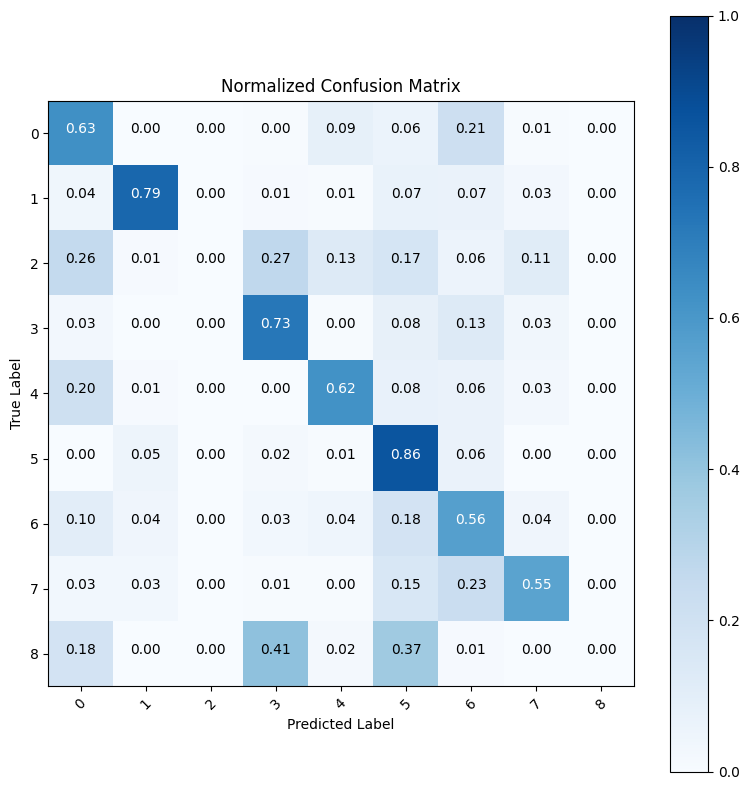

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Étape 1 : Obtenir les prédictions
true_labels = []
predicted_labels = []

# Parcourez le dataset de validation
for images, labels in val_dataset:
    # Prédictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites
    
    # Ajoutez les vraies étiquettes et prédictions
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convertir one-hot en index
    predicted_labels.extend(predicted_classes)

# Step 2: Create and Normalize the Confusion Matrix
confusion_matrix_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Step 3: Display the Normalized Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title("Normalized Confusion Matrix")
plt.colorbar()

# Add labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks, rotation=45)
plt.yticks(tick_marks, tick_marks)

# Add counts to each cell (proportions)
threshold = confusion_matrix_normalized.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_matrix_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_normalized[i, j] > threshold else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
